In [1]:
from matplotlib import pyplot as plt
import pandas as pd
from scipy.integrate import odeint
from astropy import cosmology
from IPython.display import Image
import numpy as np
%matplotlib inline
# better-looking plots
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['font.size'] = 12

C = cosmology.FlatLambdaCDM(70.0, 0.3)


In [33]:
#Record N_RD, N_BD, N_RE for each mass at each redshift bin from z=1 to z=.3


#High Mass: 11<M<11.4
rd = [134.5,114.0,38.9,26.4]
bd = [133.3,182.3,100.4,76.3]
re = [356.5,418.0,144.1,121.6]

f_RID1 = rd[0]/(rd[0]+bd[0]) #red disks / red disks + blue disks at z=1
f_DIR1 = rd[0]/(rd[0]+re[0]) #red disks / red disks + red ellipticals at z=1


f_RID3 = rd[-1]/(rd[-1]+bd[-1]) #red disks / red disks + blue disks at z=0.3
f_DIR3 = rd[-1]/(rd[-1]+re[-1]) #red disks / red disks + red ellipticals at z=0.3

In [29]:
# Low-middle mass: 10.3<M<10.7
rd = [76.0,117.7,63.0,96.0]
bd = [491.1,720.2,479.9,458.7]
re = [616.0,1077.3,408.0,317.0]

f_RID1 = rd[0]/(rd[0]+bd[0]) #red disks / red disks + blue disks at z=1
f_DIR1 = rd[0]/(rd[0]+re[0]) #red disks / red disks + red ellipticals at z=1

f_RID3 = rd[-1]/(rd[-1]+bd[-1]) #red disks / red disks + blue disks at z=0.3
f_DIR3 = rd[-1]/(rd[-1]+re[-1]) #red disks / red disks + red ellipticals at z=0.3

In [179]:
# Low mass: 9.9<M<10.3
rd = [5.8,18.4,14.7,54.9]
bd = [478.3,766.6,529.8,531.7]
re = [154.2,503.6,328.3,298.1]

f_RID1 = rd[0]/(rd[0]+bd[0]) #red disks / red disks + blue disks at z=1
f_DIR1 = rd[0]/(rd[0]+re[0]) #red disks / red disks + red ellipticals at z=1

f_RID3 = rd[-1]/(rd[-1]+bd[-1]) #red disks / red disks + blue disks at z=0.3
f_DIR3 = rd[-1]/(rd[-1]+re[-1]) #red disks / red disks + red ellipticals at z=0.3


In [2]:
states = pd.Index(('BD', 'RD', 'RE')) #only considering blue disks, red disks, red ellipticals


In [3]:
rate_labels = pd.DataFrame(index='to ' + states, columns='from ' + states,
                     data=[['$r_{BD \rightarrow BD}$', '$r_{RD \rightarrow BD}$', '$r_{RE \rightarrow BD}$'],
                           ['$r_{BD \rightarrow RD}$', '$r_{RD \rightarrow RD}$', '$r_{RE \rightarrow RD}$'],
                           ['$r_{BD \rightarrow RE}$', '$r_{RD \rightarrow RE}$', '$r_{RE \rightarrow RE}$']])
rate_labels

,from BD,from RD,from RE
to BD,$r_{BD \rightarrow BD}$,$r_{RD \rightarrow BD}$,$r_{RE \rightarrow BD}$
to RD,$r_{BD \rightarrow RD}$,$r_{RD \rightarrow RD}$,$r_{RE \rightarrow RD}$
to RE,$r_{BD \rightarrow RE}$,$r_{RD \rightarrow RE}$,$r_{RE \rightarrow RE}$


$\frac{dN_{BD}}{dt}|_{m}= N_{BD} \, (-r_{BD \rightarrow RD} - r_{BD \rightarrow RE} - (\alpha \times sSFR(t))$

$\frac{dN_{RD}}{dt}|_{m} = - N_{RD} \, r_{RD \rightarrow RE} + N_{BD} \, r_{BD \rightarrow RD}$

$\frac{dN_{RE}}{dt}|_{2m} = + N_{BD} \, r_{BD \rightarrow RE} + N_{RD} \, r_{RD \rightarrow RE} \, + N_{RE} r_{RE \rightarrow RE} $

$\alpha = (1+\alpha_s)-m/M^*$

$sSFR(t) = 2.5\times(\frac{t}{3.5 Gyr})^-2.2$

In [4]:
def alpha(a_s,M_star,m):
    alpha = (1+a_s) - m/M_star
    return alpha
def sSFR(t):
    sSFR = 2.5*(t/3.5)**(-2.2)
    return sSFR


In [41]:
# Set rates per galaxy in Gyr^{-1} at fiducial redshift
rates = pd.DataFrame(index='to ' + states, columns='from ' + states,
                     data=np.zeros((3, 3)))
rates['from BD']['to RD'] = 0.01
rates['from RD']['to RE'] = 0.01
rates['from BD']['to RE'] = 0.01
rates['from RE']['to RE']=.05
#for s in states:
#    rates['from ' + s]['to ' + s] = 0
#    rates['from ' + s]['to ' + s] = - rates['from ' + s].sum()
rates

,from BD,from RD,from RE
to BD,0.00,0.00,0.00
to RD,0.01,0.00,0.00
to RE,0.01,0.01,0.05


In [83]:
def rate_matrix(rates,m,t):
    #create matrix using rates to reproduce differential equations when dotted with vector N0
    rate_mtrx = pd.DataFrame(data=np.zeros((3, 3)))
    a_s = -1.4 
    M_star = 10.82
    rate_mtrx[0][0] = rates['from BD']['to RD'] - rates['from BD']['to RE'] - alpha(a_s,M_star,m)*sSFR(t)
    rate_mtrx[0][1] = rates['from BD']['to RD']
    rate_mtrx[0][2] = rates['from BD']['to RE']
    rate_mtrx[1][2] = rates['from RD']['to RE']
    rate_mtrx[2][2] = .5*rates['from RE']['to RE']
    return rate_mtrx

In [85]:
## Test it out: now we should have a matrix which, when dotted with N0, reproduces the derivatives we defined in 3

rate_matrix(rates,11,C.age(.5).value)

,0,1,2
0,0.513235,0.00,0.000
1,0.010000,0.00,0.000
2,0.010000,0.01,0.025


In [86]:
def model(N, t, rates, rate_matrix_fn, m):
    rate_mtrx = rate_matrix_fn(rates,m,t)
    return np.dot(rate_mtrx, N)

In [87]:
# initial relative number densities
# for log(M*/Msun) ~ 10.5, starting with f_{R|D} ~ 0.05 and f_{D|R} ~ 0.1 at z ~ 1
N0 = pd.Series(index=states, data=[bd[0], rd[0], re[0]])
N0 /= N0.sum()  # normalise to unity
N0

BD    0.213519
RD    0.215441
RE    0.571040
dtype: float64

In [44]:
# redshifts and times to evaluate
zstart = 1.0
zend = 0.3
z = np.linspace(zstart, zend, 100)
t = C.age(z)
t0 = C.age(zend).value
m=11

In [88]:
N = odeint(model, N0, t, args=(rates, rate_matrix, m))

In [89]:
N = pd.DataFrame(index=z, columns='$N_{' + states + '}$', data=N)
N = N[::-1] #number evolution of BD,RD,RE

In [90]:
F = pd.DataFrame(index=N.index) #evolution of fractions
F['$f_{R|D}$'] = N['$N_{RD}$'] / (N['$N_{RD}$'] + N['$N_{BD}$'])
F['$f_{D|R}$'] = N['$N_{RD}$'] / (N['$N_{RD}$'] + N['$N_{RE}$'])


In [91]:
def plot_NF(N, F):
    fig, (axN, axF) = plt.subplots(1, 2, figsize=(12, 6))
    N.plot(ax=axN)
    axN.set(xlabel='$z$', ylabel='$N(z)/N(z={:.1f})$'.format(zstart), ylim=(0, 1));
    F.plot(ax=axF)
    axF.set(xlabel='$z$', ylabel='$f(z)$', ylim=(0, 0.4));
    plt.tight_layout()

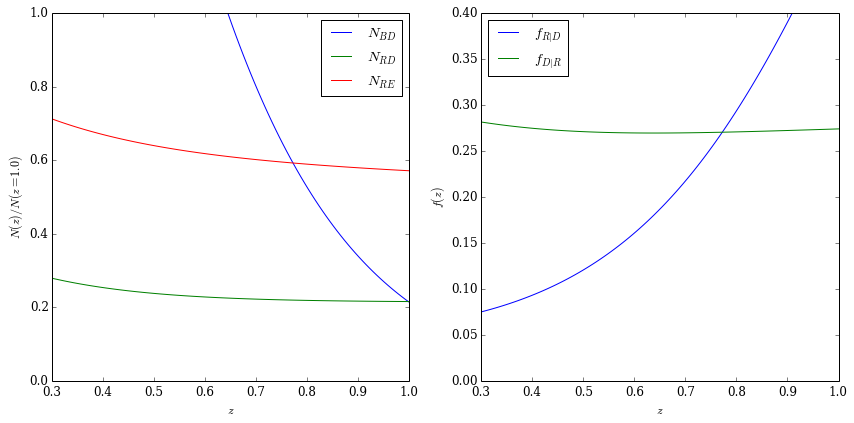

In [92]:
plot_NF(N, F)
